# Analyze mutations on host switch branches

I would like to see whether there are mutations that are associated specifically with cross-species transmission events. There are a few ways you could look at this. Here are a few ideas: 

1. For each mutation on the tree, how many times is it found on branches that are part of a host transition vs. branches that are not part of a host transition? By "part of", I mean are you on a branch that is either the parent or child branch that constitutes a host switch event? 
2. Are particular mutations enriched on branches with distinct host states? By this I mean, are there mutations that are differentially distributed among branches of type human vs. domestic? 

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from io import StringIO
import time

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

## Grab all trees and process posterior

In [4]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [5]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [6]:
"""this is a function I'm not currently using, but it will enumerate mutations as well as which host type branches
they occur on"""

def enumerate_mutations(tree):
    muts = {}
    host_branches = {}
    
    for k in tree.Objects:
        host = k.traits['typeTrait']
        if host in host_branches: 
            host_branches[host] += 1
        else:
            host_branches[host] = 1
        
        if 'mutations' in k.traits: 
            mutation = k.traits['mutations']
            site = mutation[1:-1]
            if site not in muts: 
                muts[site] = [host]
            else: 
                muts[site].append(host)
            
    return(muts, host_branches)

In [7]:
def tabulate_mutations(mutations_dict):
    output_dict = {}
    for mut in mutations_dict:
        output_dict[mut] = {}
        hosts = list(set(mutations_dict[mut]))
        for h in hosts: 
            output_dict[mut][h] = mutations_dict[mut].count(h)
    
    return(output_dict)

In [8]:
def muts_on_branch(branch):
    
    if 'mutations' in branch.traits: 
        mutations = branch.traits['mutations']
    
    else: 
        mutations = ""
    
    return(mutations)

In [9]:
def enumerate_child_traits(branch):
    child_traits = []
    
    current_trait = branch.traits['typeTrait']
    
    for c in branch.children: 
        child_trait = c.traits['typeTrait']
        child_traits.append(child_trait)
    
    if set(child_traits) == {current_trait}:
        host_switch_branch = "no"
    
    else:
        host_switch_branch = "yes"
        
    return(host_switch_branch)

In [10]:
"""given a parent node and its child, infer whether either the parent or child has a mutation on it"""

def mut_near_migration_event(parent, child):
    
    if 'mutations' in parent.traits:
        parent_mutation = parent.traits['mutations']
    else:
        parent_mutation = ""
        
    if 'mutations' in child.traits:
        child_mutation = child.traits['mutations']
        
    else:
        child_mutation = ""
        
    return(parent_mutation, child_mutation)

In [11]:
"""this function will iterate through the tree, and record each inferred migration event along the phylogeny. It
will also capture the inferred time of the migration event as a decimal date, and whether the parent or child branch
surrounding the migration event have any mutations on them. These values are stored in a dictionary where the 
key is a number to keep track of the total number of migration events on the tree, and the value is a dictionary
housing data about the migration event. this includes its type, the parent and child host states, date, and mutations"""

def enumerate_mutations_and_migration_events(tree):
        
    output_dict = {}
    branch_counter = 0
        
    for k in tree.Objects:
        trait = k.traits['typeTrait']
        parent_node = k.parent
        
        if 'typeTrait' not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits['typeTrait']
        
            # if the current trait differs from the parent trait, then this is a host switch event. Enumerate 
            # mutations on the parent and current branch"""
            if trait != parent_trait:
                host_switch_event = "yes"
                migration_event = parent_trait + "-to-" + trait

                # does a mutation occur on the parent or child branch? 
                parent_mut, child_mut = mut_near_migration_event(parent_node, k)
                
                # write out the information for the parent and child branches
                branch_counter += 1
                output_dict[branch_counter] = {"type":migration_event, "host_switch": host_switch_event,
                                                 "host":parent_trait, "role":"parent", "mutations":parent_mut}
                
                branch_counter += 1
                output_dict[branch_counter] = {"type":migration_event, "host_switch": host_switch_event,
                                                 "host":trait, "role":"child", "mutations":child_mut}


            
            # if the current trait is the same as the parent trait:
            else:
                
                # if the branch is a node and it has no children or if you are a leaf, then you are not a host 
                # switch branch, and we can record your mutations and be done
                if (k.branchType == 'node' and len(k.children) == 0) or k.branchType == 'leaf':
                    mutations = muts_on_branch(k)
                    migration_event = "within-" + trait
                    host_switch_event = "no"
                    
                    branch_counter += 1
                    output_dict[branch_counter] = {"type":migration_event, "host_switch": host_switch_event,
                                                 "host":trait, "role":"on", "mutations":mutations}
                
                # if you are a node and you do have children, we need to check your children to make sure that 
                # they do not have a trait change. If they do, then you are part of a host switch.
                elif len(k.children) > 0:
                    host_switch_event = enumerate_child_traits(k)
                    
                    # if we are on a host_switch branch, pass
                    if host_switch_event == "yes":
                        to_record = "no"
                    else: 
                        mutations = muts_on_branch(k)
                        migration_event = "within-" + trait
                        
                        branch_counter += 1
                        output_dict[branch_counter] = {"type":migration_event, "host_switch": host_switch_event,
                                                 "host":trait, "role":"on", "mutations":mutations}
                
    return(output_dict)

In [12]:
# trees file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.trees"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.trees"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.trees"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/no-human-mig-2021-03-31/2021-03-15-mascot-3deme-no-human-mig.combined.trees"}

In [13]:
to_run = skyline_human_off

trees_file_path = to_run['trees']
label = to_run['label']

burnin_percent = 0

In [189]:
all_trees = trees_file_path
burnin_percent = 0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


0


In [192]:
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    mutations_dict = {}
    
    for line in infile:
        if 'tree STATE_' in line:
            
            if tree_counter >= burnin:
                tree_counter += 1
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                tree.setAbsoluteTime(2019.227)
                
                # iterate through the tree and pull out all migration events
                mutations_dict[tree_counter] = enumerate_mutations_and_migration_events(tree)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", tree_counter, "trees")

this took 505.1699073314667 seconds ( 8.419498455524444  minutes) to run on 3287 trees


In [194]:
"""this will generate a multi-index dataframe from the migrations dictionary"""

mutations_df = pd.DataFrame.from_dict({(i,j): mutations_dict[i][j] 
                           for i in mutations_dict.keys() 
                           for j in mutations_dict[i].keys()},
                       orient='index')
 
mutations_df.reset_index(inplace=True)
mutations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'branch_number'}, inplace=True)
mutations_df.head()

,tree_number,branch_number,type,host_switch,host,role,mutations
0,1,1,within-domestic,no,domestic,on,T138C
1,1,2,within-domestic,no,domestic,on,
2,1,3,within-domestic,no,domestic,on,A202G
3,1,4,domestic-to-wild,yes,domestic,parent,
4,1,5,domestic-to-wild,yes,wild,child,T447A


In [232]:
# write out to tsv
# mutations_df.to_csv("/Users/lmoncla/src/h5n1-host-classification/beast/mutations-on-branches-"+current_date+".tsv", sep="\t")

In [22]:
mutations_df = pd.DataFrame.from_csv("/Users/lmoncla/src/h5n1-host-classification/beast/mutations-on-branches-2021-05-21.tsv", sep="\t")

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [23]:
"""count the total number of branches that are host switch branches vs. within-host branches"""

total_host_switch_branches = mutations_df["host_switch"].tolist().count('yes')
total_non_branches = mutations_df["host_switch"].tolist().count('no')

print(total_host_switch_branches, total_non_branches)
expected_host_switch = total_host_switch_branches/(total_non_branches + total_host_switch_branches)
expected_non = total_non_branches/(total_non_branches + total_host_switch_branches)

print(expected_host_switch, expected_non)

2387734 3794372
0.3862331056762857 0.6137668943237142


In [37]:
"""are there more mutations on host switch branches than non-host switch branches?"""

host_switch_with_mut = len(mutations_df[(mutations_df["host_switch"] == "yes") & (~mutations_df["mutations"].isnull())])
host_switch_no_mut = len(mutations_df[(mutations_df["host_switch"] == "yes") & (mutations_df["mutations"].isnull())])

within_host_with_mut = len(mutations_df[(mutations_df["host_switch"] == "no") & (~mutations_df["mutations"].isnull())])
within_host_no_mut = len(mutations_df[(mutations_df["host_switch"] == "no") & (mutations_df["mutations"].isnull())])

print(host_switch_with_mut, host_switch_no_mut, host_switch_with_mut/host_switch_no_mut)
print(within_host_with_mut, within_host_no_mut, within_host_with_mut/within_host_no_mut)

1735717 652017 2.6620732281520265
2766440 1027932 2.691267515750069


In [36]:
from scipy.stats import fisher_exact

table = [[host_switch_with_mut,within_host_with_mut],[host_switch_no_mut,within_host_no_mut]]
oddsr, p = fisher_exact(table, alternative='two-sided')

print(oddsr,p)

0.9891522164083693 4.2005857331723705e-09


In [39]:
"""what about subsetting by different types of host switching events"""

wild_domestic_with_mut = len(mutations_df[(mutations_df["type"] == "wild-to-domestic") & (~mutations_df["mutations"].isnull())])
wild_domestic_no_mut = len(mutations_df[(mutations_df["type"] == "wild-to-domestic") & (mutations_df["mutations"].isnull())])

within_wild_with_mut = len(mutations_df[(mutations_df["type"] == "within-wild") & (~mutations_df["mutations"].isnull())])
within_wild_no_mut = len(mutations_df[(mutations_df["type"] == "within-wild") & (mutations_df["mutations"].isnull())])

print(wild_domestic_with_mut, wild_domestic_no_mut, wild_domestic_with_mut/wild_domestic_no_mut)
print(within_wild_with_mut, within_wild_no_mut, within_wild_with_mut/within_wild_no_mut)

976019 322081 3.0303526131625276
893402 469377 1.9033783078420972


In [40]:
"""repeat with domestic to human"""

domestic_human_with_mut = len(mutations_df[(mutations_df["type"] == "domestic-to-human") & (~mutations_df["mutations"].isnull())])
domestic_human_no_mut = len(mutations_df[(mutations_df["type"] == "domestic-to-human") & (mutations_df["mutations"].isnull())])

within_domestic_with_mut = len(mutations_df[(mutations_df["type"] == "within-domestic") & (~mutations_df["mutations"].isnull())])
within_domestic_no_mut = len(mutations_df[(mutations_df["type"] == "within-domestic") & (mutations_df["mutations"].isnull())])

print(domestic_human_with_mut, domestic_human_no_mut, domestic_human_with_mut/domestic_human_no_mut)
print(within_domestic_with_mut, within_domestic_no_mut, within_domestic_with_mut/within_domestic_no_mut)

531574 236666 2.2460936509680307
1754360 537769 3.2622929175910103


In [ ]:
"""the above analysis doesn't make sense unless we normalize to branch length; obviously there are going to be more 
mutations in wild birds, because the branches are much longer. So we want a mutation rate per host basically, 
rather than a uniform rate"""

In [16]:
def convert_to_counts_dict(input_df):
    
    trees = set(input_df['tree_number'].tolist())
    output_dict = {}

    for t in trees:
        output_dict[t] = {}
        local_df1 = input_df[input_df['tree_number'] == t]

        muts_to_query = set(local_df1['mutations'].tolist())
        muts_to_query = [x for x in muts_to_query if str(x) != '']

        for m in muts_to_query:
            output_dict[t][m] = {}
            local_df = local_df1[local_df1['mutations'] == m]
            value_counts = local_df['host_switch'].value_counts()

            for i in range(len(value_counts)):
                count = value_counts[i]
                index = value_counts.index.tolist()[i]

                output_dict[t][m][index] = count
                
    return(output_dict)

In [17]:
def convert_to_counts_df(counts_dict):
    """this will generate a multi-index dataframe from the migrations dictionary"""

    df = pd.DataFrame.from_dict({(i,j): counts_dict[i][j] 
                               for i in counts_dict.keys() 
                               for j in counts_dict[i].keys()},
                           orient='index')

    df.reset_index(inplace=True)
    df.rename(columns={'level_0': 'tree_number', 'level_1': 'mutation'}, inplace=True)
    df = df.fillna(0)
    df['total_count'] = df['yes'] + df['no']

    print(len(df))
    return(df)

In [198]:
mutation_counts_dict = convert_to_counts_dict(mutations_df)
mutation_counts_df = convert_to_counts_df(mutation_counts_dict)

2451747


In [200]:
mutation_counts_df.head()

,tree_number,mutation,yes,no,total_count
0,1,A1038C,1.0,0.0,1.0
1,1,A1038G,0.0,1.0,1.0
2,1,A1041G,1.0,1.0,2.0
3,1,A1044T,1.0,0.0,1.0
4,1,A1050G,1.0,1.0,2.0


In [233]:
# write out to tsv
# mutation_counts_df.to_csv("/Users/lmoncla/src/h5n1-host-classification/beast/mutations-counts-on-branches-"+current_date+".tsv", sep="\t")

In [20]:
mutation_counts_df = pd.DataFrame.from_csv("/Users/lmoncla/src/h5n1-host-classification/beast/mutations-counts-on-branches-2021-05-21.tsv", sep="\t")

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [21]:
mutation_counts_df['ratio'] = mutation_counts_df['yes']/mutation_counts_df['total_count']
mutation_counts_df.head()

,tree_number,mutation,yes,no,total_count,ratio
0,1,A1038C,1.0,0.0,1.0,1.0
1,1,A1038G,0.0,1.0,1.0,0.0
2,1,A1041G,1.0,1.0,2.0,0.5
3,1,A1044T,1.0,0.0,1.0,1.0
4,1,A1050G,1.0,1.0,2.0,0.5


In [228]:
df = mutation_counts_df[(mutation_counts_df['total_count'] >= 5) & (mutation_counts_df['ratio'] > 0.8)]
print(len(set(df['mutation'].tolist())))
print(len(df))
print(set(df['mutation'].tolist()))
df.head()

97
1556
{'C261T', 'C156T', 'A29G', 'G114A', 'A635G', 'T300C', 'G774A', 'C357T', 'T9C', 'C43T', 'A375G', 'A66G', 'G210A', 'A294G', 'G348A', 'C789T', 'A30G', 'T43C', 'C1134T', 'C606T', 'C138T', 'T72C', 'G312A', 'A64G', 'G630A', 'T663C', 'T35C', 'A207G', 'C183T', 'T436C', 'C279T', 'G320A', 'C333T', 'C37T', 'G1245A', 'A332G', 'C9A', 'G489A', 'C166T', 'A276G', 'G52A', 'T660C', 'G1041A', 'G414A', 'C195T', 'G588A', 'A225G', 'C480T', 'C592T', 'A11C', 'G533A', 'G488A', 'A246G', 'G427A', 'A488G', 'G56A', 'A456G', 'C620A', 'G589A', 'A67G', 'C966T', 'G900A', 'T330C', 'G111A', 'T99C', 'A240G', 'G325A', 'A532G', 'A201G', 'T490C', 'G594A', 'G227A', 'T32C', 'G483A', 'G309A', 'T90C', 'C475T', 'T141C', 'C326T', 'A173G', 'G27A', 'T612C', 'G616A', 'G535T', 'A1278G', 'A171G', 'T198C', 'C9T', 'T216C', 'A11G', 'G36A', 'T498C', 'G135A', 'A228G', 'C465T', 'C57T', 'C687T'}


,tree_number,mutation,yes,no,total_count,ratio
3695,5,T99C,5.0,0.0,5.0,1.000000
4175,6,G36A,5.0,1.0,6.0,0.833333
5838,8,T35C,6.0,0.0,6.0,1.000000
6322,9,C687T,5.0,0.0,5.0,1.000000
8421,12,A67G,5.0,1.0,6.0,0.833333


In [ ]:
#### did not run past here yet

In [230]:
df_melted = df.melt(id_vars = ['mutation','tree_number','total_count','ratio'])
df_melted.columns = ['mutation','tree_number','total_count','ratio','host_switch','counts']
df_melted.head()

,mutation,tree_number,total_count,ratio,host_switch,counts
0,T99C,5,5.0,1.000000,yes,5.0
1,G36A,6,6.0,0.833333,yes,5.0
2,T35C,8,6.0,1.000000,yes,6.0
3,C687T,9,5.0,1.000000,yes,5.0
4,A67G,12,6.0,0.833333,yes,5.0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


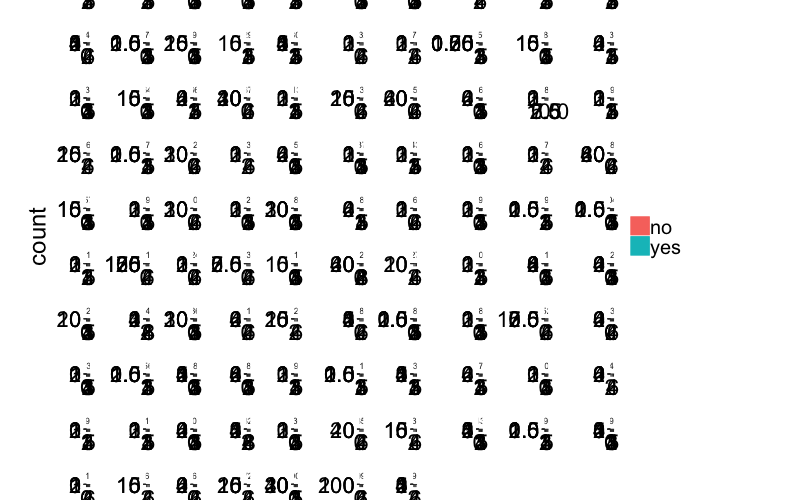

In [231]:
%%R -w 800 -h 500 -u px -i df_melted,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("muts-on-branches-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=df_melted, aes(x=counts, color=host_switch, fill=host_switch)) + 
    geom_histogram(position="dodge")+
    facet_wrap(~mutation, scales="free")+
    #geom_line(stat="count")+
    #labs(x="\nmonth", y="proportion of migration events\nof that type\n")+
    #scale_color_manual(values=c(domestic_to_human=human_color,wild_to_domestic=wild_color,domestic_to_wild=domestic_color,wild_to_human="grey50"))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(1,12,1))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 20, height = 20, device = "pdf", path = "figures", dpi = 300)
p

In [4]:
# first, read in the master dataframe 
migrations_df = pd.read_csv("/Users/lmoncla/src/h5n1-host-classification/beast/migrations-2021-05-18.tsv", sep="\t")
migrations_df.head()

,Unnamed: 0,tree_number,migration_event_number,type,date,parent_host,parent_mutations,child_host,child_mutations,calendar_date,year,month
0,0,1,1,domestic-to-wild,1998.117545,domestic,NaN,wild,T447A,1998-02-12,1998,2
1,1,1,2,wild-to-domestic,2004.666964,wild,G202A,domestic,C43T,2004-08-31,2004,8
2,2,1,3,domestic-to-wild,2006.028482,domestic,C43T,wild,G428A,2006-01-11,2006,1
3,3,1,4,wild-to-domestic,2013.538958,wild,NaN,domestic,G730A,2013-07-16,2013,7
4,4,1,5,domestic-to-human,2013.845776,domestic,G730A,human,C1230T,2013-11-05,2013,11


In [ ]:
for t in set(migrations_df['type'].tolist()):
    local_df = migrations_df[migrations_df['type'] == t]
    total_transitions = len(local_df)
    
    n_parent_muts = len(list(filter(lambda a: a != "", local_df['parent_mutations'].tolist())))
    n_child_muts = len(list(filter(lambda a: a != "", local_df['child_mutations'].tolist())))
    
    print(t, n_parent_muts, n_child_muts, total_transitions)
    print(n_parent_muts/total_transitions, n_child_muts/total_transitions)

In [ ]:
# pull out every unique mutation that occurs
import math

all_muts = migrations_df['parent_mutations'].tolist()
all_muts.extend(migrations_df['child_mutations'].tolist())
all_muts = list(set(all_muts))

# remove nans
all_muts = [x for x in all_muts if str(x) != 'nan']
print(len(all_muts))

In [ ]:
output_dict = {}
for mut in all_muts[0:10]:
    output_dict[mut] = {}
    
    local_df = migrations_df[(migrations_df['parent_mutations'] ==  mut)|(migrations_df['child_mutations'] ==  mut)]
    
    # use valuecounts to get the count of types for each mutation
    value_counts = local_df['type'].value_counts()
    x = local_df['tree_number'].value_counts
    for i in range(len(value_counts)):
        count = value_counts[i]
        index = value_counts.index.tolist()[i]
        output_dict[mut][index] = count

local_df['tree_number'].value_counts()

In [ ]:
mut_counts_df = pd.DataFrame.from_dict(output_dict, orient="index")
mut_counts_df = mut_counts_df.fillna(0)
mut_counts_df.head()

In [ ]:
mut_counts_df['total_counts'] = mut_counts_df['domestic-to-wild'] + mut_counts_df['wild-to-domestic'] + mut_counts_df['domestic-to-human'] + mut_counts_df['wild-to-human']
mut_counts_df['prop_domestic_to_wild'] = mut_counts_df['domestic-to-wild']/mut_counts_df['total_counts']
mut_counts_df['prop_wild_to_domestic'] = mut_counts_df['wild-to-domestic']/mut_counts_df['total_counts']
mut_counts_df['prop_domestic_to_human'] = mut_counts_df['domestic-to-human']/mut_counts_df['total_counts']
mut_counts_df['prop_wild_to_human'] = mut_counts_df['wild-to-human']/mut_counts_df['total_counts']

mut_counts_df[(mut_counts_df['prop_domestic_to_human'] > 0.5) & (mut_counts_df['total_counts'] > 100)]